#  Hybrid Classical-Quantum Transfer Learning for Cardiomegaly Detection in Chest X-Rays

## Example of 10-fold cross-validation

## load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import copy
        
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM
from nngeometry.object import PMatKFAC, PMatDense
%matplotlib inline

# sklearn import
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)
    
from watermark import watermark
%reload_ext watermark
%watermark 
%watermark --iversions

C:\Users\decpi\Anaconda3\envs\qamp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last updated: 2023-05-01T22:14:02.544120+02:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.5.2
torch      : 1.12.1
numpy      : 1.23.1
seaborn    : 0.12.0
torchvision: 0.13.1
pandas     : 1.4.4



In [2]:
import time
n_qubits = 4                     # Number of qubits.
q_depth = 6                      # Depth of the quantum circuit (number of variational layers).
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights.

step = 10e-4                     # Learning rate.
weight_decay = 10e-4             # Weight_decay for learning rate.
batch_size = 8                   # Number of samples for each training step.
init_epochs = 2                  # Number of init epochs.
train_epochs = 18                # Number of training epochs.
step_size= 2                     # Learning rate changing epochs.
gamma_lr_scheduler = 0.3         # Learning rate reduction applied every step_size epochs.  

start_time = time.time()         # Start of the computation timer

## get dataset from disk file chexpert-corrected

In [3]:
from tqdm import tqdm 
import time
start = time.time()
img_size = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)), 
        transforms.CenterCrop((224,224)),
        #transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


data_dir = 'chexpert-corrected/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    if transforms.Normalize in data_transforms['val'].transforms:
        norm = tranform_start[trans_list.index(transforms.Normalize)]
        mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
        std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
        img = std * input_tensor + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

Time elapsed:  0.2460315227508545


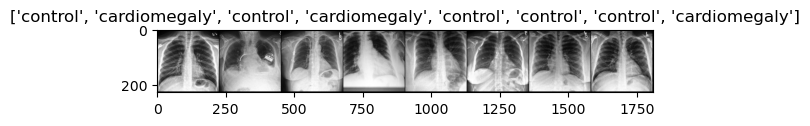

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#resize image
import cv2
import PIL
from glob import glob

def read_img(img_path,tranform_):
    img = cv2.imread(img_path)
    transform = transforms.Compose(tranform_)
    img = transform(PIL.Image.fromarray(img))
    return img

print('Scans found:', len(image_datasets['train'].imgs)+ len(image_datasets['val'].imgs))

Scans found: 2436


### GradCam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50,resnext50_32x4d,resnet18,densenet161,wide_resnet50_2, densenet121, densenet161
from PIL import Image

### pre-process dataset
generate image from address

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = 'cpu' #qiskit don't support gpu on windows

cpu


In [8]:
from tqdm import tqdm 
train_img = []
train_ids = []
train_y = []

img_size=256
tranform_ = [transforms.Resize((img_size, img_size)), 
             transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=0.5),
             #transforms.ToTensor(),
             #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]

train_img = []
train_ids = []
train_y = []

for img_path in tqdm(image_datasets["train"].imgs):
    train_img.append(read_img(img_path[0],tranform_))
    train_ids.append(img_path[0].split("\\")[2])
    train_y.append(img_path[1])
    
#valid_img = []
#valid_ids = []
#valid_y = []
#
#for img_path in tqdm(image_datasets["val"].imgs):
#    valid_img.append(read_img(img_path[0],tranform_))
#    valid_ids.append(img_path[0].split("\\")[2])
#    valid_y.append(img_path[1])
    
test_img = []
test_ids = []
test_y = []
for img_path in tqdm(image_datasets["val"].imgs):
    test_img.append(read_img(img_path[0],tranform_))
    test_ids.append(img_path[0].split("\\")[2])
    test_y.append(img_path[1])

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:03<00:00, 192.13it/s]


In [9]:
total_img = train_img + test_img
total_ids = train_ids + test_ids
total_y = train_y + test_y

In [10]:
total_img[0:2]

[<PIL.Image.Image image mode=RGB size=224x224 at 0x1FE37951ED0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1FE37951EA0>]

#### we need no difference between train and test transform, because concanated to total

## Neural Network

In [12]:
from math import pi
from scipy.special import logsumexp
import numpy as np


# This class is used to calculate the effective dimension of a model (classical or quantum)
# It implicitly computed the normalised Fisher information (which is called fhat) and then computes the eff dimension


class EffectiveDimension:
    def __init__(self, model, num_thetas, num_inputs):
        """
        Computes the effective dimension for a parameterised model.
        :param model: class instance
        :param num_thetas: int, number of parameter sets to include
        :param num_inputs: int, number of input samples to include
        """
        self.model = model
        self.d = model.d
        self.num_thetas = num_thetas
        self.num_inputs = num_inputs
        # Stack data together and combine parameter sets to make calcs more efficient
        rep_range = np.tile(np.array([num_inputs]), num_thetas)
        params = np.random.uniform(self.model.thetamin, self.model.thetamax, size=(self.num_thetas, model.d))
        self.params = np.repeat(params, repeats=rep_range, axis=0)
        x = np.random.normal(0, 1, size=(self.num_inputs, self.model.inputsize))
        self.x = np.tile(x, (self.num_thetas, 1))

    def get_fhat(self):
        """
        :return: ndarray, f_hat values of size (num_inputs, d, d)
        """
        grads = self.model.get_gradient(params=self.params, x=self.x)  # get gradients, dp_theta
        output = self.model.forward(params=self.params, x=self.x)  # get model output
        fishers = self.model.get_fisher(gradients=grads, model_output=output)
        fisher_trace = np.trace(np.average(fishers, axis=0))  # compute the trace with all fishers
        # average the fishers over the num_inputs to get the empirical fishers
        fisher = np.average(np.reshape(fishers, (self.num_thetas, self.num_inputs, self.d, self.d)), axis=1)
        f_hat = self.d * fisher / fisher_trace  # calculate f_hats for all the empirical fishers
        return f_hat, fisher_trace

    def eff_dim(self, f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(self.d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(self.num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return effective_dim

### training function

In [16]:
import copy
from torchsummary import summary as quick_sum # this is buggy, but light
from torchinfo import summary # this is good, but take a lot of memory
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score,confusion_matrix,classification_report
save_result = True
if save_result == True:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    result_OUT = f"image_result/freezer_init_{time_str}"
    os.makedirs(result_OUT, exist_ok=True)

In [17]:
def get_variable_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [18]:
# used for each fold
def transform_function(train, test):
    import time
    start = time.time()

    # * better way
    
    global train_y
    global train_ds
    global train_dataloader
    global train_size
    global test_y
    global test_y_label
    global test_ds
    global test_dataloader
    global test_size

    tranform_ = [#transforms.Resize((img_size, img_size)), 
                 #transforms.CenterCrop((224,224)),
                 #transforms.RandomRotation(30),
                 #transforms.RandomHorizontalFlip(p=0.5),
                #transforms.RandomVerticalFlip(p=0.5),
                 #transforms.RandomAutocontrast(p=1.0),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
    transform = transforms.Compose(tranform_)

    train_imgg = []
    train_y = []
    for i in tqdm(train):
        img = transform(total_img[i])
        train_y.append(total_y[i])
        train_imgg.append(img)
    ##train_ds=torch.tensor(np.array(train_img), device=device).float()
    train_y = torch.tensor(train_y, device=device).float()
    train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
    train_size = len(train_dataloader)
    
    test_img_ = []
    test_y_label = []
    for i in tqdm(test):
        img = transform(total_img[i])
        test_y_label.append(total_y[i])
        test_img_.append(img)
    #test_ds=torch.tensor(np.array(test_img_), device=device).float()
    test_y = torch.tensor(test_y_label, device=device).float()
    test_ds = TensorDataset(torch.stack(test_img_).to(device), test_y)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)#, sampler= sampler)
    test_size = len(test_dataloader)

    own_elapsed = time.time() - start
    print("Time elapsed: ", own_elapsed)

In [19]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Cardiomegaly?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

In [20]:
def grad_camera(models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    """ Train function
    Args:
        models: pytroch model
        target_layers :  target layer of the model
        picture_select (str): select picture from all the image
        transform_start : input picture display
        transform_end : output picture display
    Returns:
        pytorch model
    Raises:
        None
    """
    #target_layers = target_layers
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
        #return tranform_start
    input_tensor = torch.stack([read_img(eval(f'image_datasets["train"].imgs{picture_select}[0]'), tranform_start)])#torch.stack(train_img)[:1,:,:,:]# Create an input tensor image for your model..
    print(input_tensor.numpy()[0].shape)
    y= models(input_tensor.to(device))
    # Note: input_tensor can be a batch tensor with several images!
    
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAMPlusPlus(model=models, target_layers=target_layers)#, use_cuda=False)
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor.to(device))[0, :]#, targets=targets)[0, :]
    
    # In this example grayscale_cam has only one image in the batch:
    if transform_end == None:
        trans_list = list(map(type, tranform_start))
        input_tensor = input_tensor.numpy()[0]
        input_tensor = np.transpose(input_tensor, (1,2,0))
        if transforms.Normalize in trans_list:
            #img = np.transpose(input_tensor, (1,2,0))
            # We apply the inverse of the initial normalization operation.
            norm = tranform_start[trans_list.index(transforms.Normalize)]
            mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
            std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
            img = std * input_tensor + mean  
            input_tensor = np.clip(img, 0, 1)
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)
        
    y_probb = nn.Sigmoid()(y)[0]
    df = image_datasets["train"].imgs
    plt.title(f'Cardiomegaly?\n true:{eval(f"df{picture_select}[1]")}\n pred[no/yes]:{np.round(y_probb.cpu().detach().numpy(),3)}', fontsize=20)
    #Image.fromarray(visualization, 'RGB')
    plt.imshow(visualization)
    if (save_result == True and name != None):
        plt.savefig(f"{result_OUT}/{name}_visual_img.png")
    return visualization

In [21]:
def train_model(model, criterion, optimizer,scheduler, 
                num_epochs, fold = 0, loss_save=None,
                scheduler_set = ["outside_train"],
                sig_out = True,transform = True, save = True):
    """ Train function
    Args:
        model : pytroch model
        criterion :  Criterion
        optimizer : optimize
        scheduler : scheduler
        num_epochs (int): Number of epochs
        loss_save (bool): select model save condition, 
            it can be 'None' for best_loss_train, 'True' for best_acc or False for best_loss (default=None)
        scheduler_set (list): The set the scheduler place, 
            it can include ('inside_train', 'outside_train', 'inside_valid', 'outside_valid', outside_loss_valid)
        sig_out (bool): training sigmoid output
        transform (bool): transform each epoch
    Returns:
        pytorch model
    Raises:
        None
    """
    #qamp_IMAGE_DIR = "qamp"
    start = time.time()
    
    #layer_collection = LayerCollection.from_model(model)
    #d = layer_collection.numel()
    #print('d= ', d)
    name = get_variable_name(model)[0] + "-" + str(fold).zfill(2)
    print('name:',name)
    
        
    train_loss = []
    train_loss_list = []
    training_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0   # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    opt_rate=[]
    for epoch in range(num_epochs):
        if transform:
            trans_start = time.time()
            tranform_ = [#transforms.Resize((img_size, img_size)), 
                 #transforms.CenterCrop((224,224)),
                 #transforms.RandomRotation(30),
                 #transforms.RandomHorizontalFlip(p=.5),
                 #transforms.RandomVerticalFlip(p=.5),
                 transforms.RandAugment(),
                 #transforms.RandomAdjustSharpness(sharpness_factor=2),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomInvert(),
                 transforms.RandomAutocontrast(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            transform = transforms.Compose(tranform_)
    
        running_loss = 0.0
        running_corrects = 0
        print(epoch+1,'Training started:')
        #for dataset_size_multiplier in range(5):
        for index, data in enumerate(tqdm(train_dataloader)):
            inputs, labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
            #running_loss = 0.0
            # Set model to training mode
            model.train() 
            
            # Each epoch has a training and validation phase
            batch_size_ = len(inputs)
            optimizer.zero_grad()
            
            # Iterate over data.
            #n_batches = dataset_sizes[phase] // batch_size
            # Track/compute gradient and make an optimization step only when training
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                
                if len(outputs.shape) == 1:
                    outputs = torch.stack([outputs])
                if sig_out == True:
                    outputs = nn.Sigmoid()(outputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)#torch.stack(label_list))
                loss.backward()
                optimizer.step()
                if "inside_train" in scheduler_set:
                    scheduler.step()
                
            
            # Print iteration results
            running_loss += loss.item() #*inputs.size(0)#* batch_size_
            train_loss.append(loss.item() )#*inputs.size(0))#*batch_size_)
            batch_corrects = torch.sum(preds == labels.data).item()
            running_corrects += batch_corrects
            if (index+1)%train_size == 0:
                print('Train Epoch: {}/{} train loss {:.4f} Acc batch: {:.4f} learning_rate: {:.4f}'.format(epoch + 1, num_epochs, running_loss/train_size, running_corrects/train_ds.tensors[0].size(0),optimizer.state_dict()['param_groups'][0]['lr']))
                training_loss.append(running_loss/train_size)
        if running_corrects/len(train_ds) > best_acc_train:
            best_acc_train = running_loss
        if running_loss < best_loss_train:
            best_loss_train = running_corrects/len(train_ds)#round(new_train_df.shape[0]*split_size)
        if "outside_train" in scheduler_set:
            scheduler.step()
                
        train_loss_list.append(np.mean(train_loss))
        
    if save_result: np.savetxt(f"{result_OUT}/{name}_training_loss.csv", training_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss.csv", train_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss_list.csv", train_loss_list)#save
            
    own_elapsed = time.time() - start
    print("Time elapsed: ", own_elapsed)
    
    # Print final results 
      
    if len(train_loss_list) > 1:
        plt.rcParams["figure.figsize"] = (5.5, 4)
        plt.title("Training loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Training loss")
        plt.plot(range(0,len(train_loss_list)), train_loss_list, color="blue")
        if save_result == True: plt.savefig(f"{result_OUT}/{name}_train_loss.png")#save pic
        plt.show()
    
    return model








## init_freezer

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def n_count_parameters(model):
    return sum(p.numel() for p in model.parameters() if not(p.requires_grad))

In [23]:
def train_func(cnn_model,init_step, train_step, fold = 0, save_model=save_result):
    criterion = nn.CrossEntropyLoss()
    if init_step > 0:
        optimizer = torch.optim.Adam(cnn_model.parameters(), lr=step, weight_decay = weight_decay)
        
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
        cnn_model = train_model(cnn_model.to(device), 
                                criterion, optimizer,exp_lr_scheduler, 
                                init_step, fold, None,["outside_train"], False, True,False)
    
    for param in cnn_model.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=(step*0.3)*(np.floor(init_step/2)) if init_step > 0  else step, weight_decay = weight_decay)
    
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
    cnn_model = train_model(cnn_model.to(device), 
                            criterion, optimizer,exp_lr_scheduler, 
                            train_step, fold, None, ["outside_train"], False, True)#["outside_train"]
    
    cnn_model_visual = grad_camera(cnn_model, [cnn_model.features[-1]],[0] ,transform_start=None,
                                   transform_end=None,
                                   name=get_variable_name(cnn_model)[0] + "-" + str(fold).zfill(2))
    
    return cnn_model

In [24]:
 def prob_please(model, fold = 0, sig_out = True, criterion = nn.CrossEntropyLoss()):   
    
    name = get_variable_name(model)[0] + "-" + str(fold).zfill(2)

    with torch.no_grad():
            model.eval()
            
            y_pred_prob = []
            
            for index, data in enumerate(tqdm(test_dataloader)):
                model.eval()
                batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
                with torch.set_grad_enabled(False):
                    outputs = model(batch_inputs)
                    proba = nn.Sigmoid()(outputs)[0][1].tolist()
                    y_pred_prob.append(proba)
                                
            y_pred = np.rint(np.array(y_pred_prob))
            
            print(classification_report(test_y, y_pred))
            conf_matrix(test_y, y_pred)           
            plt.figure(figsize = (5.5, 4))
            fpr, tpr, _ =roc_curve(test_y, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
            plt.plot([0, 1], [0, 1],'r--')
            plt.title('ROC curve',fontsize=25)
            plt.ylabel('True Positive Rate',fontsize=18)
            plt.xlabel('False Positive Rate',fontsize=18)
            plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
            plt.show()
    
    if save_result: np.savetxt(f"{result_OUT}/{name}_y_pred_prob.csv", y_pred_prob)#save        
    if save_result: np.savetxt(f"{result_OUT}/{name}_test_y_label.csv", test_y_label)#save
    return y_pred_prob     

In [25]:
def prob_loop(sample,models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
    input_tensor = torch.stack([read_img(eval(f'image_datasets[sample].imgs{picture_select}[0]'), tranform_start)])#torch.stack(val_img)[:1,:,:,:]# Create an input tensor image for your model..
    y= models(input_tensor.to(device))
    
    y_probb = nn.Sigmoid()(y)[0]
    return y_probb


def make_df_y_probb(sample,model) :  
    df_y_probb = pd.DataFrame(columns=['image', 'p_yes', 'p_no'])
    df = image_datasets[sample].imgs
    for i in tqdm(range(len(df))):
        image_name = df[i][0][-10:]
        y_probb = prob_loop(sample, model, [model.features[-1]] \
            ,[i] ,transform_start=None, transform_end=None)
        y_probb = y_probb.cpu()
        p_yes = y_probb.detach().numpy()[0]
        p_no = y_probb.detach().numpy()[1]
        row = {'image' : image_name, 'p_yes': p_yes, 'p_no': p_no}
        new_df = pd.DataFrame([row])
        df_y_probb =  pd.concat([df_y_probb, new_df], axis = 0, ignore_index=True)
    return df_y_probb

def plot_ROC(name,y_true, y_score):

    # ROC Curve and AUROC
    plt.figure(0).clf()
    if np.sum(y_true) != 0.:        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = round(roc_auc_score(y_true, y_score), 4)
        plt.plot(fpr,tpr,label=name + ", AUC =" + str(auc))
    if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
    plt.legend()
    plt.show()

def make_csv(model, sample="val",result=True):
    df = make_df_y_probb(sample,model)
    if sample == "val":
        df_list = 361*[1] + 369*[0]
    elif sample == "train":
        df_list = 850*[1] + 856*[0]
    df = df.assign(label = df_list)

    pred_list = np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no))
    df = df.assign(cmg_pred = pred_list)
    
   
    pred_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    df = df.assign(pred = pred_list)
    
    df = df.rename(columns={"cmg_pred": "prob"})
    if sample == "val":
        df.sort_values(by = 'image')[0:16]
    elif sample == "train":
        df.sort_values(by = 'image')
    if save_result: df.to_csv(f'{result_OUT}/y_probbs_{get_variable_name(model)[0]}_{sample}.csv', index = False)
    
    if result:
        name = get_variable_name(model)[0]
        df_val = pd.read_csv(f'{result_OUT}/y_probbs_{name}_{sample}.csv') 
        prediction = np.array(df_val.prob) 
        name_ROC = f"Cardiomegaly - {name}_{sample}"
        plot_ROC(name_ROC, np.array(df_val.label), prediction)
        print(classification_report(np.array(df_val.label),  (prediction+ 0.5).astype('int32')))#prediction))
    return df

### densenet121


10


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 449.73it/s]


Time elapsed:  4.5917112827301025
name: densenet121_model_fc10_18-00
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [05:57<00:00,  1.30s/it]


Train Epoch: 1/2 train loss 0.6147 Acc batch: 0.6752 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:58<00:00,  1.09s/it]

Train Epoch: 2/2 train loss 0.5731 Acc batch: 0.7026 learning_rate: 0.0010
Time elapsed:  655.4659075737


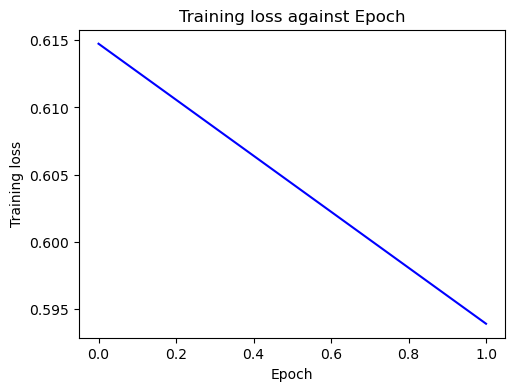

name: densenet121_model_fc10_18-00
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:38<00:00,  3.21s/it]


Train Epoch: 1/18 train loss 0.4378 Acc batch: 0.8025 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [15:02<00:00,  3.29s/it]


Train Epoch: 2/18 train loss 0.3368 Acc batch: 0.8549 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:36<00:00,  3.20s/it]


Train Epoch: 3/18 train loss 0.2680 Acc batch: 0.8960 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:17<00:00,  3.13s/it]


Train Epoch: 4/18 train loss 0.1814 Acc batch: 0.9348 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:40<00:00,  3.22s/it]


Train Epoch: 5/18 train loss 0.0945 Acc batch: 0.9722 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:04<00:00,  3.74s/it]


Train Epoch: 6/18 train loss 0.0364 Acc batch: 0.9918 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:06<00:00,  3.97s/it]


Train Epoch: 7/18 train loss 0.0215 Acc batch: 0.9968 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:17<00:00,  4.00s/it]


Train Epoch: 8/18 train loss 0.0245 Acc batch: 0.9945 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:18<00:00,  4.01s/it]


Train Epoch: 9/18 train loss 0.0327 Acc batch: 0.9895 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:16<00:00,  4.00s/it]


Train Epoch: 10/18 train loss 0.0124 Acc batch: 0.9982 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:12<00:00,  3.99s/it]


Train Epoch: 11/18 train loss 0.0119 Acc batch: 0.9986 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:14<00:00,  4.00s/it]


Train Epoch: 12/18 train loss 0.0144 Acc batch: 0.9986 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:23<00:00,  4.03s/it]


Train Epoch: 13/18 train loss 0.0088 Acc batch: 0.9986 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:19<00:00,  4.01s/it]


Train Epoch: 14/18 train loss 0.0166 Acc batch: 0.9959 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:15<00:00,  4.00s/it]


Train Epoch: 15/18 train loss 0.0126 Acc batch: 0.9991 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:12<00:00,  3.99s/it]


Train Epoch: 16/18 train loss 0.0199 Acc batch: 0.9950 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:14<00:00,  4.00s/it]


Train Epoch: 17/18 train loss 0.0117 Acc batch: 0.9977 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:17<00:00,  4.01s/it]

Train Epoch: 18/18 train loss 0.0246 Acc batch: 0.9936 learning_rate: 0.0000
Time elapsed:  18569.39197087288


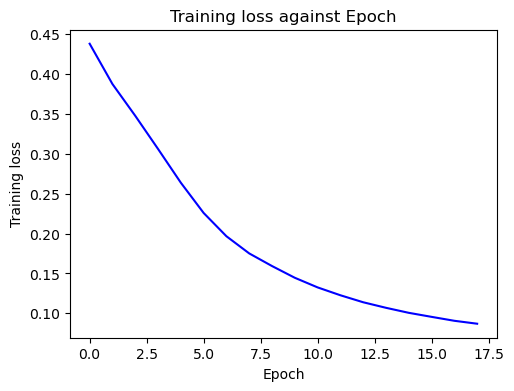

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:46<00:00,  5.22it/s]


              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       114
         1.0       0.85      0.92      0.88       130

    accuracy                           0.87       244
   macro avg       0.87      0.87      0.87       244
weighted avg       0.87      0.87      0.87       244



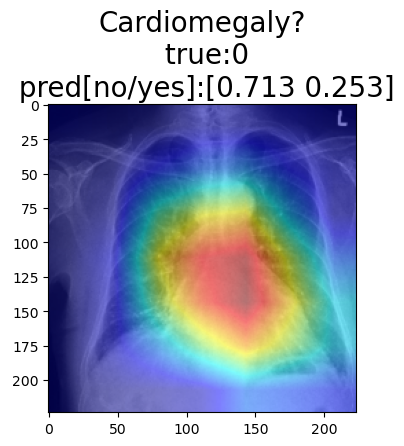

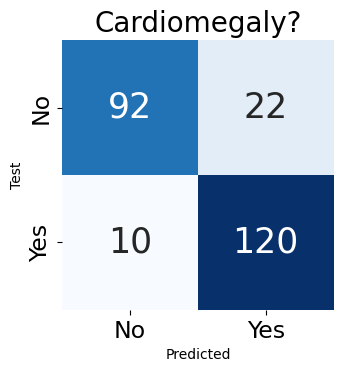

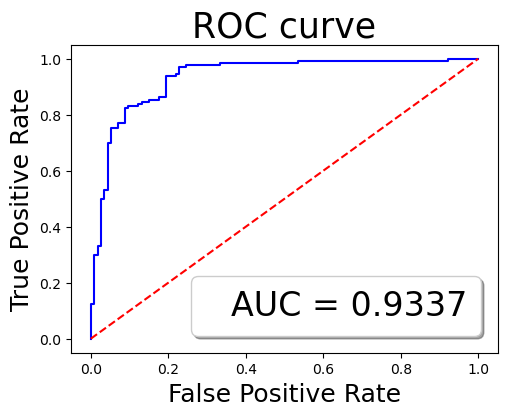

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:02<00:00, 115.66it/s]


Time elapsed:  13.520670652389526
name: densenet121_model_fc10_18-01
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:44<00:00,  1.04s/it]


Train Epoch: 1/2 train loss 0.5975 Acc batch: 0.6743 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:42<00:00,  1.03s/it]

Train Epoch: 2/2 train loss 0.5561 Acc batch: 0.7199 learning_rate: 0.0010
Time elapsed:  566.7085118293762


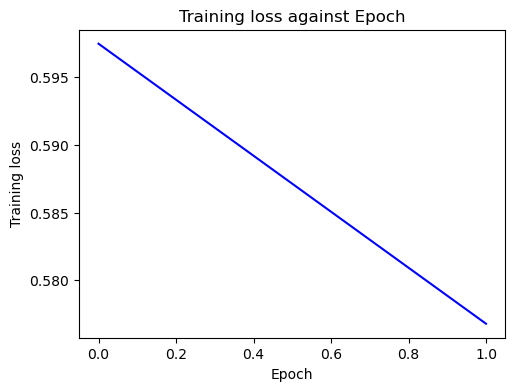

name: densenet121_model_fc10_18-01
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:18<00:00,  3.13s/it]


Train Epoch: 1/18 train loss 0.4461 Acc batch: 0.7984 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:14<00:00,  3.12s/it]


Train Epoch: 2/18 train loss 0.3710 Acc batch: 0.8417 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:13<00:00,  3.11s/it]


Train Epoch: 3/18 train loss 0.3045 Acc batch: 0.8750 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:15<00:00,  3.12s/it]


Train Epoch: 4/18 train loss 0.2293 Acc batch: 0.9115 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:32<00:00,  3.18s/it]


Train Epoch: 5/18 train loss 0.1151 Acc batch: 0.9653 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:51<00:00,  3.69s/it]


Train Epoch: 6/18 train loss 0.0702 Acc batch: 0.9799 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:23<00:00,  4.03s/it]


Train Epoch: 7/18 train loss 0.0474 Acc batch: 0.9891 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:13<00:00,  3.99s/it]


Train Epoch: 8/18 train loss 0.0272 Acc batch: 0.9950 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:18<00:00,  4.01s/it]


Train Epoch: 9/18 train loss 0.0213 Acc batch: 0.9964 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:56<00:00,  3.93s/it]


Train Epoch: 10/18 train loss 0.0197 Acc batch: 0.9968 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:40<00:00,  4.09s/it]


Train Epoch: 11/18 train loss 0.0173 Acc batch: 0.9977 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:05<00:00,  3.96s/it]


Train Epoch: 12/18 train loss 0.0185 Acc batch: 0.9973 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:44<00:00,  3.89s/it]


Train Epoch: 13/18 train loss 0.0145 Acc batch: 0.9982 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:31<00:00,  3.84s/it]


Train Epoch: 14/18 train loss 0.0140 Acc batch: 0.9968 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:26<00:00,  3.82s/it]


Train Epoch: 15/18 train loss 0.0206 Acc batch: 0.9964 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:28<00:00,  3.83s/it]


Train Epoch: 16/18 train loss 0.0109 Acc batch: 0.9991 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:30<00:00,  3.84s/it]


Train Epoch: 17/18 train loss 0.0272 Acc batch: 0.9927 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:04<00:00,  3.96s/it]

Train Epoch: 18/18 train loss 0.0303 Acc batch: 0.9918 learning_rate: 0.0000
Time elapsed:  18228.488802433014


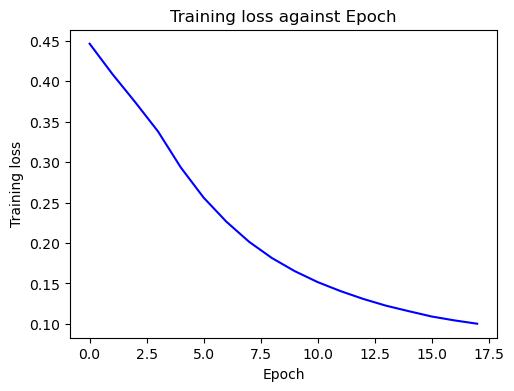

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:44<00:00,  5.54it/s]


              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       118
         1.0       0.82      0.88      0.85       126

    accuracy                           0.84       244
   macro avg       0.84      0.84      0.84       244
weighted avg       0.84      0.84      0.84       244



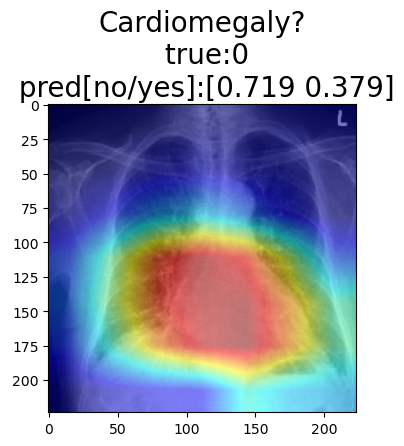

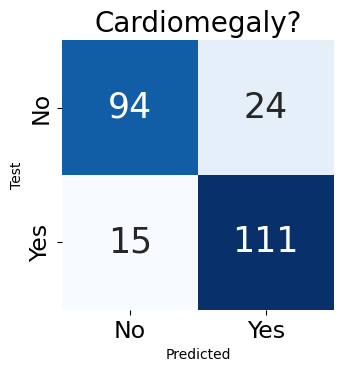

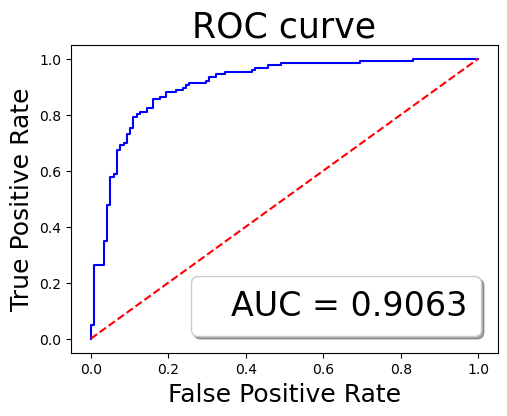

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:01<00:00, 182.99it/s]


Time elapsed:  8.887087345123291
name: densenet121_model_fc10_18-02
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:39<00:00,  1.02s/it]


Train Epoch: 1/2 train loss 0.6150 Acc batch: 0.6720 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:29<00:00,  1.02it/s]

Train Epoch: 2/2 train loss 0.5408 Acc batch: 0.7336 learning_rate: 0.0010
Time elapsed:  549.0856096744537


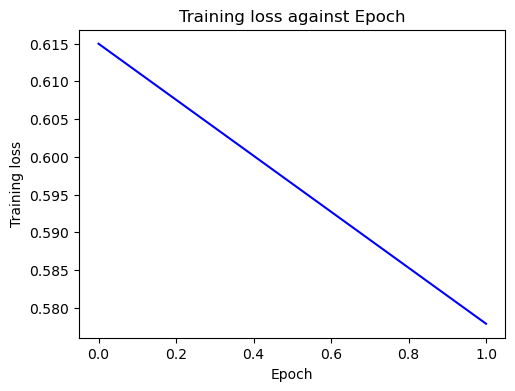

name: densenet121_model_fc10_18-02
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:21<00:00,  2.93s/it]


Train Epoch: 1/18 train loss 0.4553 Acc batch: 0.7979 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:44<00:00,  3.01s/it]


Train Epoch: 2/18 train loss 0.3599 Acc batch: 0.8467 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:17<00:00,  2.91s/it]


Train Epoch: 3/18 train loss 0.2568 Acc batch: 0.9028 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:11<00:00,  2.89s/it]


Train Epoch: 4/18 train loss 0.1614 Acc batch: 0.9380 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:19<00:00,  2.92s/it]


Train Epoch: 5/18 train loss 0.1005 Acc batch: 0.9676 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [14:46<00:00,  3.24s/it]


Train Epoch: 6/18 train loss 0.0671 Acc batch: 0.9790 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [15:43<00:00,  3.44s/it]


Train Epoch: 7/18 train loss 0.0400 Acc batch: 0.9895 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:04<00:00,  3.52s/it]


Train Epoch: 8/18 train loss 0.0288 Acc batch: 0.9941 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:58<00:00,  3.93s/it]


Train Epoch: 9/18 train loss 0.0208 Acc batch: 0.9964 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:07<00:00,  3.97s/it]


Train Epoch: 10/18 train loss 0.0128 Acc batch: 0.9991 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:09<00:00,  3.76s/it]


Train Epoch: 11/18 train loss 0.0137 Acc batch: 0.9986 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:23<00:00,  3.59s/it]


Train Epoch: 12/18 train loss 0.0168 Acc batch: 0.9968 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:13<00:00,  3.55s/it]


Train Epoch: 13/18 train loss 0.0226 Acc batch: 0.9954 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:16<00:00,  3.56s/it]


Train Epoch: 14/18 train loss 0.0218 Acc batch: 0.9954 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:13<00:00,  3.55s/it]


Train Epoch: 15/18 train loss 0.0242 Acc batch: 0.9941 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:29<00:00,  3.61s/it]


Train Epoch: 16/18 train loss 0.0108 Acc batch: 0.9986 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:19<00:00,  3.58s/it]


Train Epoch: 17/18 train loss 0.0213 Acc batch: 0.9941 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:16<00:00,  3.57s/it]

Train Epoch: 18/18 train loss 0.0136 Acc batch: 0.9991 learning_rate: 0.0000
Time elapsed:  16858.908463954926


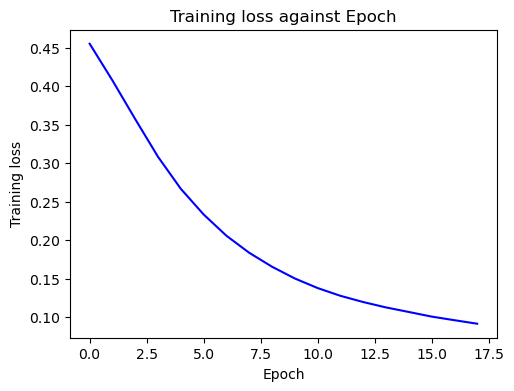

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:40<00:00,  5.97it/s]


              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85       123
         1.0       0.83      0.88      0.85       121

    accuracy                           0.85       244
   macro avg       0.85      0.85      0.85       244
weighted avg       0.85      0.85      0.85       244



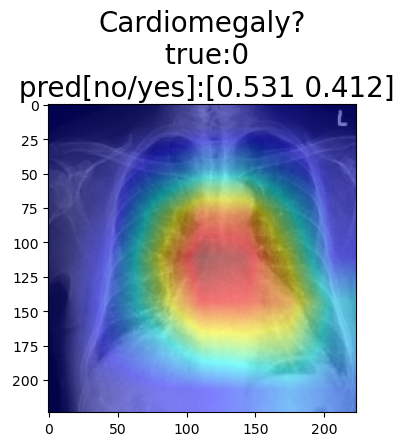

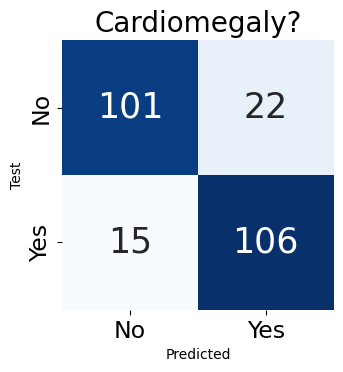

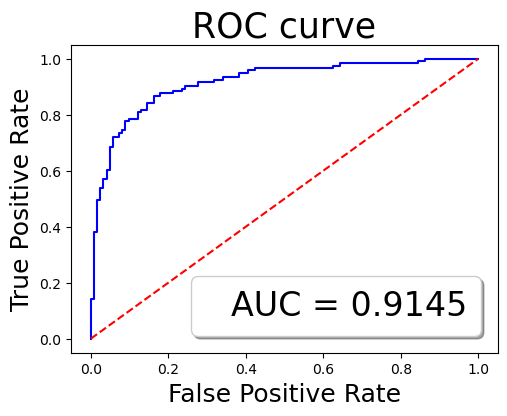

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 272.04it/s]


Time elapsed:  7.499257564544678
name: densenet121_model_fc10_18-03
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:25<00:00,  1.03it/s]


Train Epoch: 1/2 train loss 0.5877 Acc batch: 0.6966 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:23<00:00,  1.04it/s]

Train Epoch: 2/2 train loss 0.5400 Acc batch: 0.7331 learning_rate: 0.0010
Time elapsed:  528.6093974113464


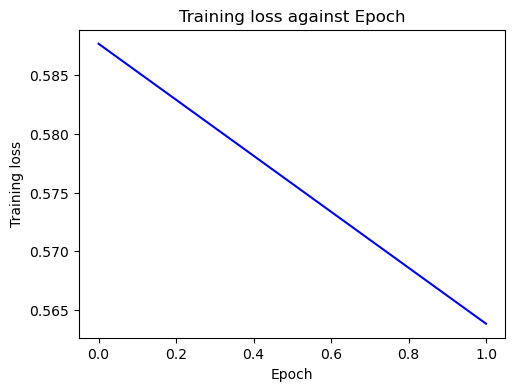

name: densenet121_model_fc10_18-03
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:09<00:00,  2.88s/it]


Train Epoch: 1/18 train loss 0.4566 Acc batch: 0.7970 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:04<00:00,  2.86s/it]


Train Epoch: 2/18 train loss 0.3664 Acc batch: 0.8376 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:08<00:00,  2.88s/it]


Train Epoch: 3/18 train loss 0.2740 Acc batch: 0.8932 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:07<00:00,  2.87s/it]


Train Epoch: 4/18 train loss 0.2154 Acc batch: 0.9183 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:31<00:00,  2.96s/it]


Train Epoch: 5/18 train loss 0.0982 Acc batch: 0.9676 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [15:55<00:00,  3.49s/it]


Train Epoch: 6/18 train loss 0.0541 Acc batch: 0.9863 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:52<00:00,  3.69s/it]


Train Epoch: 7/18 train loss 0.0399 Acc batch: 0.9904 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:40<00:00,  3.65s/it]


Train Epoch: 8/18 train loss 0.0349 Acc batch: 0.9918 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:46<00:00,  3.67s/it]


Train Epoch: 9/18 train loss 0.0207 Acc batch: 0.9968 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:49<00:00,  3.68s/it]


Train Epoch: 10/18 train loss 0.0216 Acc batch: 0.9968 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:48<00:00,  3.68s/it]


Train Epoch: 11/18 train loss 0.0159 Acc batch: 0.9982 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:05<00:00,  3.74s/it]


Train Epoch: 12/18 train loss 0.0405 Acc batch: 0.9891 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:04<00:00,  3.74s/it]


Train Epoch: 13/18 train loss 0.0229 Acc batch: 0.9945 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:57<00:00,  3.71s/it]


Train Epoch: 14/18 train loss 0.0212 Acc batch: 0.9959 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:57<00:00,  3.71s/it]


Train Epoch: 15/18 train loss 0.0229 Acc batch: 0.9945 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:04<00:00,  3.74s/it]


Train Epoch: 16/18 train loss 0.0232 Acc batch: 0.9945 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:55<00:00,  3.71s/it]


Train Epoch: 17/18 train loss 0.0391 Acc batch: 0.9872 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:07<00:00,  3.75s/it]

Train Epoch: 18/18 train loss 0.0130 Acc batch: 0.9995 learning_rate: 0.0000
Time elapsed:  17105.892827272415


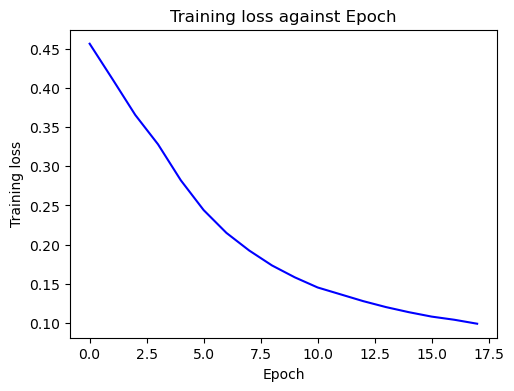

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:41<00:00,  5.92it/s]


              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88       130
         1.0       0.86      0.88      0.87       114

    accuracy                           0.88       244
   macro avg       0.88      0.88      0.88       244
weighted avg       0.88      0.88      0.88       244



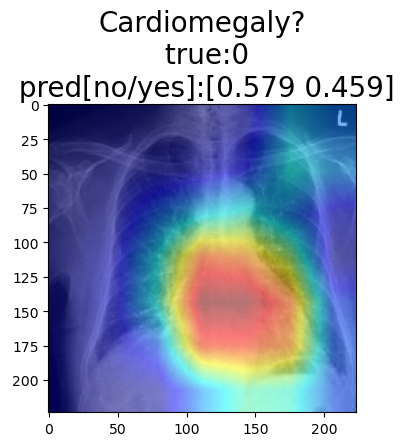

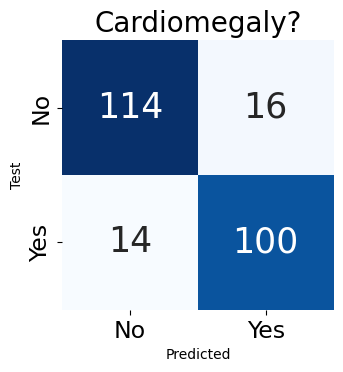

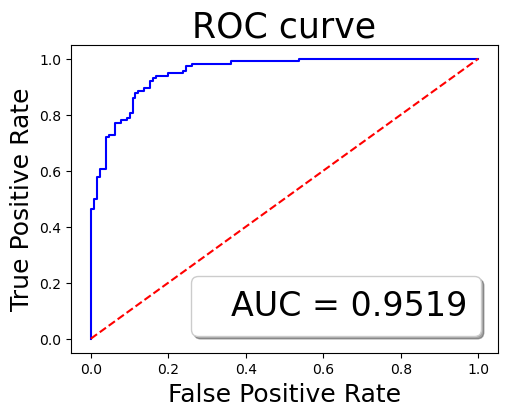

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 294.81it/s]


Time elapsed:  6.659213304519653
name: densenet121_model_fc10_18-04
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:24<00:00,  1.03it/s]


Train Epoch: 1/2 train loss 0.6330 Acc batch: 0.6583 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:22<00:00,  1.04it/s]

Train Epoch: 2/2 train loss 0.5465 Acc batch: 0.7167 learning_rate: 0.0010
Time elapsed:  527.6344804763794


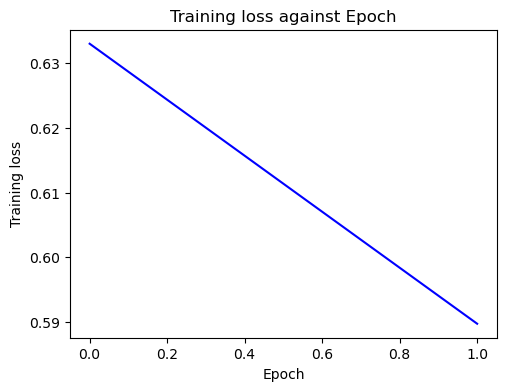

name: densenet121_model_fc10_18-04
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:05<00:00,  2.87s/it]


Train Epoch: 1/18 train loss 0.4503 Acc batch: 0.7961 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:38<00:00,  2.99s/it]


Train Epoch: 2/18 train loss 0.3669 Acc batch: 0.8376 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:47<00:00,  3.02s/it]


Train Epoch: 3/18 train loss 0.2741 Acc batch: 0.8942 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:12<00:00,  2.89s/it]


Train Epoch: 4/18 train loss 0.1796 Acc batch: 0.9370 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:29<00:00,  2.95s/it]


Train Epoch: 5/18 train loss 0.0901 Acc batch: 0.9735 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [15:58<00:00,  3.50s/it]


Train Epoch: 6/18 train loss 0.0425 Acc batch: 0.9895 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:51<00:00,  3.69s/it]


Train Epoch: 7/18 train loss 0.0227 Acc batch: 0.9941 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:56<00:00,  3.71s/it]


Train Epoch: 8/18 train loss 0.0207 Acc batch: 0.9950 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:06<00:00,  3.75s/it]


Train Epoch: 9/18 train loss 0.0156 Acc batch: 0.9964 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:05<00:00,  3.74s/it]


Train Epoch: 10/18 train loss 0.0110 Acc batch: 0.9991 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:06<00:00,  3.74s/it]


Train Epoch: 11/18 train loss 0.0083 Acc batch: 1.0000 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:07<00:00,  3.75s/it]


Train Epoch: 12/18 train loss 0.0249 Acc batch: 0.9954 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:13<00:00,  3.77s/it]


Train Epoch: 13/18 train loss 0.0169 Acc batch: 0.9977 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:37<00:00,  3.86s/it]


Train Epoch: 14/18 train loss 0.0393 Acc batch: 0.9886 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:07<00:00,  3.75s/it]


Train Epoch: 15/18 train loss 0.0110 Acc batch: 0.9991 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:04<00:00,  3.74s/it]


Train Epoch: 16/18 train loss 0.0298 Acc batch: 0.9927 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:45<00:00,  3.89s/it]


Train Epoch: 17/18 train loss 0.0285 Acc batch: 0.9922 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [18:00<00:00,  3.94s/it]

Train Epoch: 18/18 train loss 0.0123 Acc batch: 0.9982 learning_rate: 0.0000
Time elapsed:  17415.683386564255


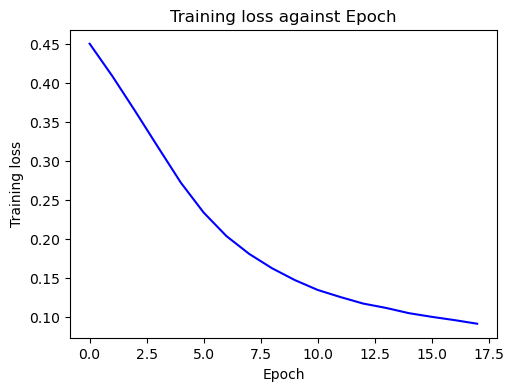

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:44<00:00,  5.52it/s]


              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       117
         1.0       0.84      0.90      0.87       127

    accuracy                           0.86       244
   macro avg       0.86      0.85      0.86       244
weighted avg       0.86      0.86      0.86       244



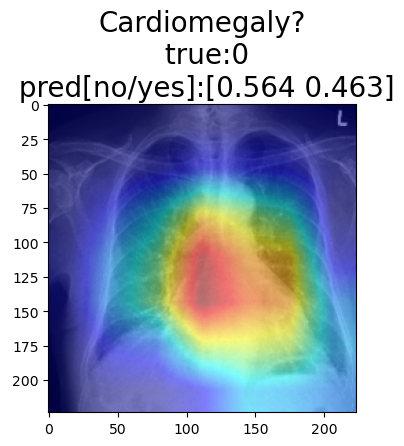

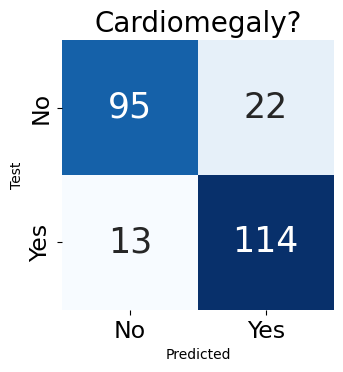

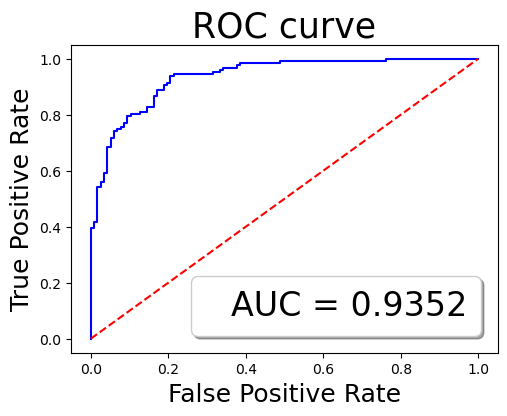

100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:01<00:00, 161.59it/s]


Time elapsed:  8.221956253051758
name: densenet121_model_fc10_18-05
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:33<00:00,  1.00it/s]


Train Epoch: 1/2 train loss 0.6057 Acc batch: 0.6911 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [04:28<00:00,  1.02it/s]


Train Epoch: 2/2 train loss 0.5432 Acc batch: 0.7372 learning_rate: 0.0010
Time elapsed:  541.4661667346954


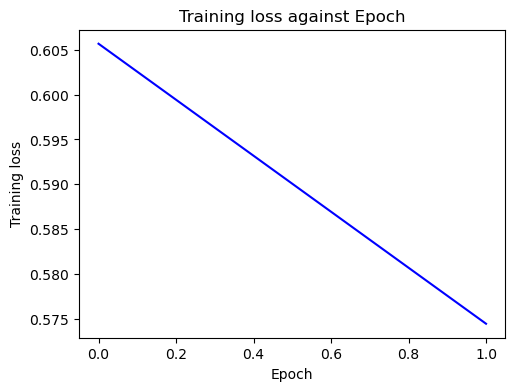

name: densenet121_model_fc10_18-05
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:14<00:00,  2.90s/it]


Train Epoch: 1/18 train loss 0.4740 Acc batch: 0.7801 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:04<00:00,  2.86s/it]


Train Epoch: 2/18 train loss 0.3757 Acc batch: 0.8371 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:09<00:00,  2.88s/it]


Train Epoch: 3/18 train loss 0.2738 Acc batch: 0.8923 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:09<00:00,  2.88s/it]


Train Epoch: 4/18 train loss 0.1912 Acc batch: 0.9243 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [13:25<00:00,  2.94s/it]


Train Epoch: 5/18 train loss 0.1037 Acc batch: 0.9658 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [15:31<00:00,  3.40s/it]


Train Epoch: 6/18 train loss 0.0379 Acc batch: 0.9922 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:35<00:00,  3.63s/it]


Train Epoch: 7/18 train loss 0.0222 Acc batch: 0.9954 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:44<00:00,  3.66s/it]


Train Epoch: 8/18 train loss 0.0164 Acc batch: 0.9982 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [17:07<00:00,  3.75s/it]


Train Epoch: 9/18 train loss 0.0094 Acc batch: 1.0000 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:50<00:00,  3.69s/it]


Train Epoch: 10/18 train loss 0.0173 Acc batch: 0.9964 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:48<00:00,  3.68s/it]


Train Epoch: 11/18 train loss 0.0117 Acc batch: 0.9986 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:51<00:00,  3.69s/it]


Train Epoch: 12/18 train loss 0.0077 Acc batch: 1.0000 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:50<00:00,  3.69s/it]


Train Epoch: 13/18 train loss 0.0185 Acc batch: 0.9968 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:48<00:00,  3.68s/it]


Train Epoch: 14/18 train loss 0.0179 Acc batch: 0.9973 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:48<00:00,  3.68s/it]


Train Epoch: 15/18 train loss 0.0074 Acc batch: 1.0000 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:49<00:00,  3.68s/it]


Train Epoch: 16/18 train loss 0.0336 Acc batch: 0.9927 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:55<00:00,  3.70s/it]


Train Epoch: 17/18 train loss 0.0167 Acc batch: 0.9977 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [16:50<00:00,  3.69s/it]

Train Epoch: 18/18 train loss 0.0148 Acc batch: 0.9959 learning_rate: 0.0000
Time elapsed:  17015.687885284424


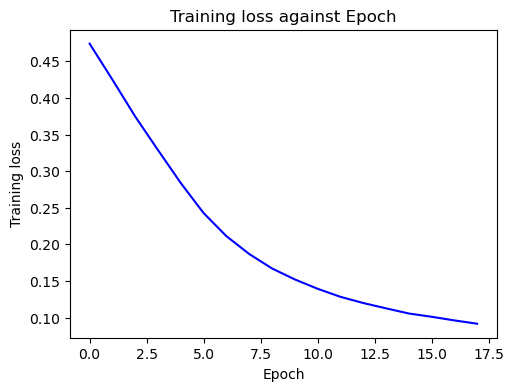

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [00:44<00:00,  5.46it/s]


              precision    recall  f1-score   support

         0.0       0.90      0.85      0.88       129
         1.0       0.84      0.90      0.87       115

    accuracy                           0.87       244
   macro avg       0.87      0.87      0.87       244
weighted avg       0.87      0.87      0.87       244



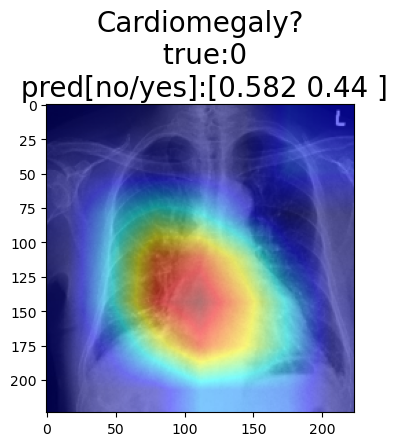

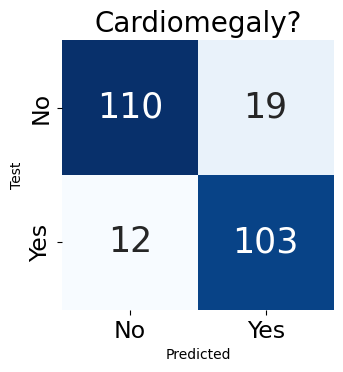

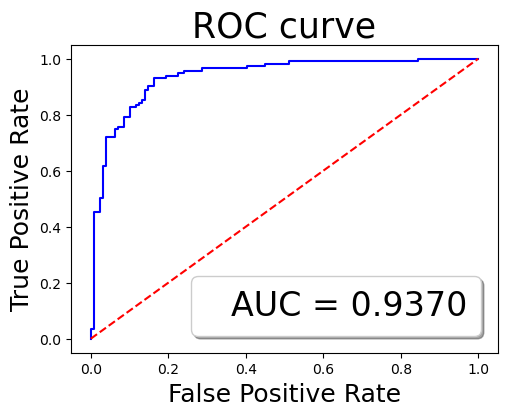

100%|███████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 203.40it/s]


Time elapsed:  7.674620628356934
name: densenet121_model_fc10_18-06
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:22<00:00,  1.05it/s]


Train Epoch: 1/2 train loss 0.6214 Acc batch: 0.6493 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:23<00:00,  1.04it/s]

Train Epoch: 2/2 train loss 0.5499 Acc batch: 0.7355 learning_rate: 0.0010
Time elapsed:  525.7190573215485


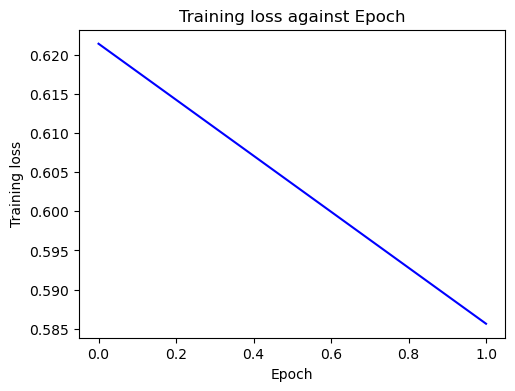

name: densenet121_model_fc10_18-06
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:04<00:00,  2.85s/it]


Train Epoch: 1/18 train loss 0.4498 Acc batch: 0.7902 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:04<00:00,  2.85s/it]


Train Epoch: 2/18 train loss 0.3645 Acc batch: 0.8463 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:03<00:00,  2.85s/it]


Train Epoch: 3/18 train loss 0.2807 Acc batch: 0.8910 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:05<00:00,  2.86s/it]


Train Epoch: 4/18 train loss 0.2201 Acc batch: 0.9207 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:18<00:00,  2.90s/it]


Train Epoch: 5/18 train loss 0.0998 Acc batch: 0.9731 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [15:35<00:00,  3.40s/it]


Train Epoch: 6/18 train loss 0.0543 Acc batch: 0.9900 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:43<00:00,  3.65s/it]


Train Epoch: 7/18 train loss 0.0420 Acc batch: 0.9913 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:56<00:00,  3.70s/it]


Train Epoch: 8/18 train loss 0.0306 Acc batch: 0.9941 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:59<00:00,  3.71s/it]


Train Epoch: 9/18 train loss 0.0288 Acc batch: 0.9950 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:07<00:00,  3.74s/it]


Train Epoch: 10/18 train loss 0.0220 Acc batch: 0.9973 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:03<00:00,  3.72s/it]


Train Epoch: 11/18 train loss 0.0168 Acc batch: 0.9986 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:27<00:00,  3.81s/it]


Train Epoch: 12/18 train loss 0.0282 Acc batch: 0.9941 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:43<00:00,  3.87s/it]


Train Epoch: 13/18 train loss 0.0240 Acc batch: 0.9973 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:29<00:00,  3.81s/it]


Train Epoch: 14/18 train loss 0.0208 Acc batch: 0.9964 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:11<00:00,  3.75s/it]


Train Epoch: 15/18 train loss 0.0308 Acc batch: 0.9932 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:06<00:00,  3.73s/it]


Train Epoch: 16/18 train loss 0.0231 Acc batch: 0.9977 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:02<00:00,  3.72s/it]


Train Epoch: 17/18 train loss 0.0227 Acc batch: 0.9968 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:03<00:00,  3.72s/it]

Train Epoch: 18/18 train loss 0.0206 Acc batch: 0.9982 learning_rate: 0.0000
Time elapsed:  17228.78599357605


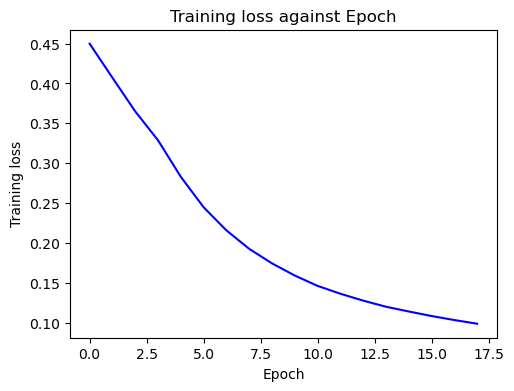

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:41<00:00,  5.89it/s]


              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       105
         1.0       0.86      0.88      0.87       138

    accuracy                           0.85       243
   macro avg       0.85      0.85      0.85       243
weighted avg       0.85      0.85      0.85       243



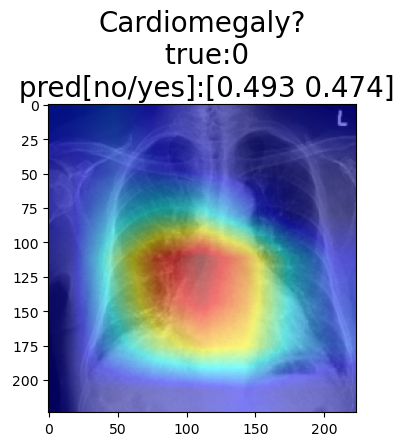

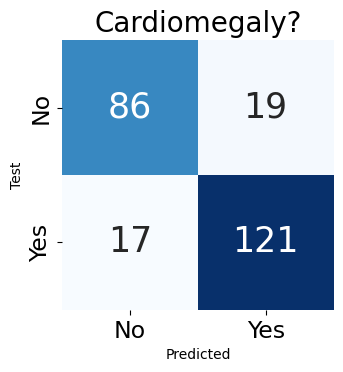

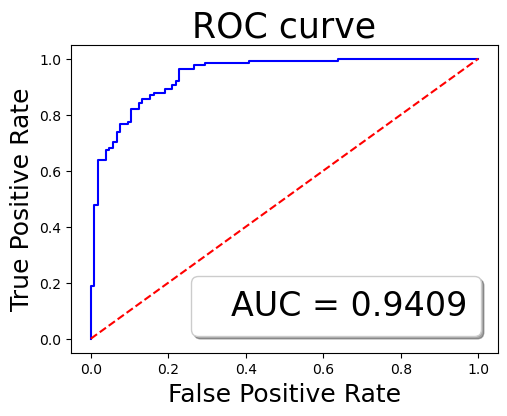

100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:02<00:00, 89.80it/s]


Time elapsed:  10.305881023406982
name: densenet121_model_fc10_18-07
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:27<00:00,  1.03it/s]


Train Epoch: 1/2 train loss 0.6096 Acc batch: 0.6776 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:23<00:00,  1.05it/s]

Train Epoch: 2/2 train loss 0.5453 Acc batch: 0.7305 learning_rate: 0.0010
Time elapsed:  530.6845500469208


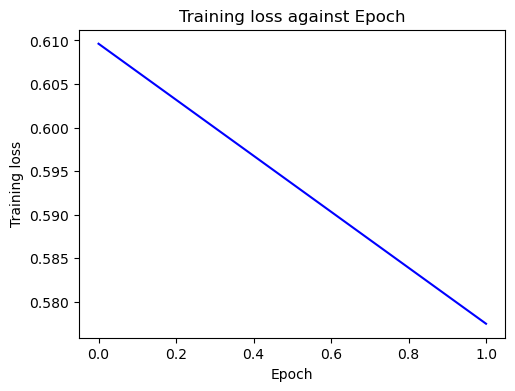

name: densenet121_model_fc10_18-07
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:04<00:00,  2.85s/it]


Train Epoch: 1/18 train loss 0.4461 Acc batch: 0.8053 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:04<00:00,  2.85s/it]


Train Epoch: 2/18 train loss 0.3603 Acc batch: 0.8477 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:04<00:00,  2.85s/it]


Train Epoch: 3/18 train loss 0.2862 Acc batch: 0.8874 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:06<00:00,  2.86s/it]


Train Epoch: 4/18 train loss 0.2119 Acc batch: 0.9234 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:42<00:00,  2.99s/it]


Train Epoch: 5/18 train loss 0.1075 Acc batch: 0.9663 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [15:02<00:00,  3.28s/it]


Train Epoch: 6/18 train loss 0.0564 Acc batch: 0.9831 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:15<00:00,  3.55s/it]


Train Epoch: 7/18 train loss 0.0522 Acc batch: 0.9872 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:25<00:00,  3.58s/it]


Train Epoch: 8/18 train loss 0.0249 Acc batch: 0.9964 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:21<00:00,  3.57s/it]


Train Epoch: 9/18 train loss 0.0265 Acc batch: 0.9954 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:22<00:00,  3.57s/it]


Train Epoch: 10/18 train loss 0.0345 Acc batch: 0.9932 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:24<00:00,  3.58s/it]


Train Epoch: 11/18 train loss 0.0333 Acc batch: 0.9913 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:28<00:00,  3.59s/it]


Train Epoch: 12/18 train loss 0.0357 Acc batch: 0.9913 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:29<00:00,  3.60s/it]


Train Epoch: 13/18 train loss 0.0265 Acc batch: 0.9950 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:42<00:00,  3.64s/it]


Train Epoch: 14/18 train loss 0.0191 Acc batch: 0.9973 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:30<00:00,  3.60s/it]


Train Epoch: 15/18 train loss 0.0194 Acc batch: 0.9964 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:36<00:00,  3.62s/it]


Train Epoch: 16/18 train loss 0.0312 Acc batch: 0.9918 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:35<00:00,  3.62s/it]


Train Epoch: 17/18 train loss 0.0209 Acc batch: 0.9973 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:29<00:00,  3.60s/it]

Train Epoch: 18/18 train loss 0.0209 Acc batch: 0.9964 learning_rate: 0.0000
Time elapsed:  16726.27073097229


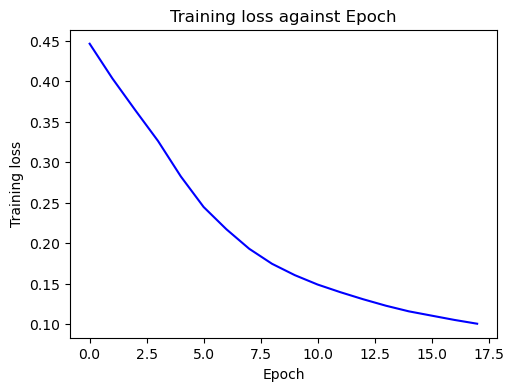

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:37<00:00,  6.44it/s]


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       127
         1.0       0.89      0.90      0.89       116

    accuracy                           0.90       243
   macro avg       0.90      0.90      0.90       243
weighted avg       0.90      0.90      0.90       243



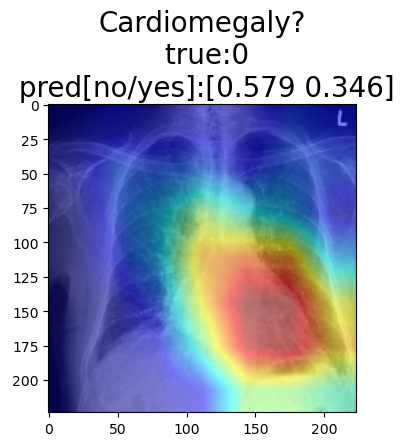

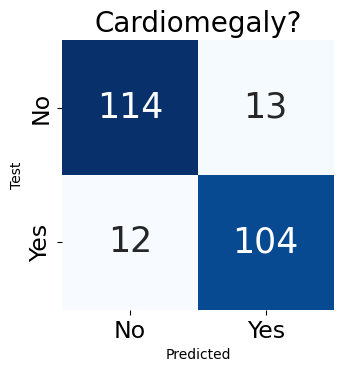

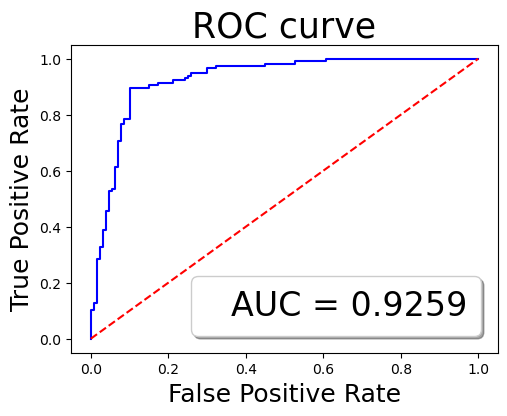

100%|███████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 284.81it/s]


Time elapsed:  9.49600863456726
name: densenet121_model_fc10_18-08
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:31<00:00,  1.01it/s]


Train Epoch: 1/2 train loss 0.6195 Acc batch: 0.6671 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:27<00:00,  1.03it/s]


Train Epoch: 2/2 train loss 0.5507 Acc batch: 0.7214 learning_rate: 0.0010
Time elapsed:  538.978189945221


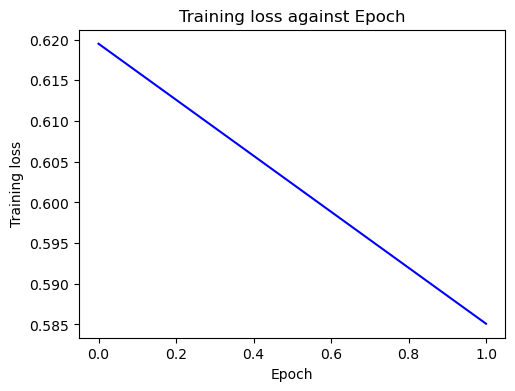

name: densenet121_model_fc10_18-08
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:13<00:00,  2.88s/it]


Train Epoch: 1/18 train loss 0.4607 Acc batch: 0.7953 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:12<00:00,  2.88s/it]


Train Epoch: 2/18 train loss 0.3701 Acc batch: 0.8395 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [14:16<00:00,  3.12s/it]


Train Epoch: 3/18 train loss 0.2781 Acc batch: 0.8865 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:19<00:00,  2.91s/it]


Train Epoch: 4/18 train loss 0.2091 Acc batch: 0.9179 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:31<00:00,  2.95s/it]


Train Epoch: 5/18 train loss 0.1013 Acc batch: 0.9699 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [15:16<00:00,  3.33s/it]


Train Epoch: 6/18 train loss 0.0354 Acc batch: 0.9932 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:14<00:00,  3.54s/it]


Train Epoch: 7/18 train loss 0.0220 Acc batch: 0.9964 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:20<00:00,  3.56s/it]


Train Epoch: 8/18 train loss 0.0166 Acc batch: 0.9968 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:38<00:00,  3.63s/it]


Train Epoch: 9/18 train loss 0.0219 Acc batch: 0.9950 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:24<00:00,  3.58s/it]


Train Epoch: 10/18 train loss 0.0149 Acc batch: 0.9986 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:25<00:00,  3.58s/it]


Train Epoch: 11/18 train loss 0.0187 Acc batch: 0.9968 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:25<00:00,  3.58s/it]


Train Epoch: 12/18 train loss 0.0177 Acc batch: 0.9977 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:24<00:00,  3.58s/it]


Train Epoch: 13/18 train loss 0.0147 Acc batch: 0.9982 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:22<00:00,  3.57s/it]


Train Epoch: 14/18 train loss 0.0192 Acc batch: 0.9968 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:33<00:00,  3.61s/it]


Train Epoch: 15/18 train loss 0.0111 Acc batch: 0.9991 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:23<00:00,  3.58s/it]


Train Epoch: 16/18 train loss 0.0148 Acc batch: 0.9982 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:22<00:00,  3.57s/it]


Train Epoch: 17/18 train loss 0.0143 Acc batch: 0.9968 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:22<00:00,  3.57s/it]

Train Epoch: 18/18 train loss 0.0148 Acc batch: 0.9991 learning_rate: 0.0000
Time elapsed:  16788.24042367935


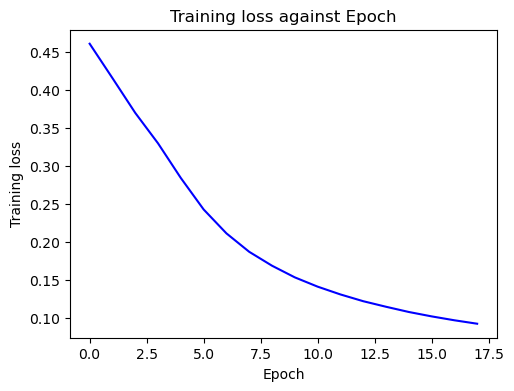

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:35<00:00,  6.87it/s]


              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       126
         1.0       0.82      0.91      0.86       117

    accuracy                           0.86       243
   macro avg       0.86      0.86      0.86       243
weighted avg       0.86      0.86      0.86       243



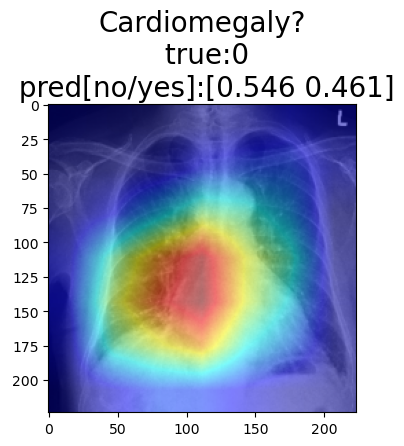

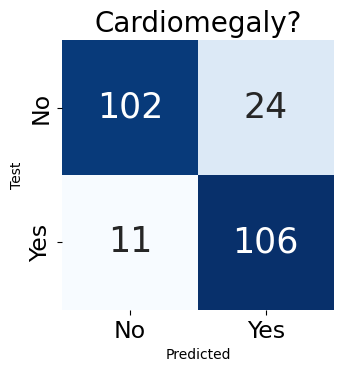

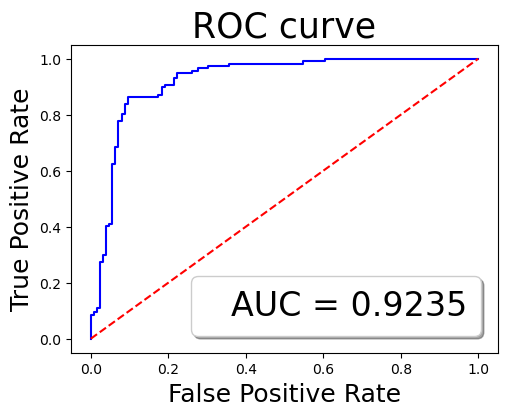

100%|███████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 300.63it/s]


Time elapsed:  7.6903510093688965
name: densenet121_model_fc10_18-09
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:29<00:00,  1.02it/s]


Train Epoch: 1/2 train loss 0.5993 Acc batch: 0.6803 learning_rate: 0.0010
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [04:27<00:00,  1.03it/s]


Train Epoch: 2/2 train loss 0.5439 Acc batch: 0.7355 learning_rate: 0.0010
Time elapsed:  536.6231331825256


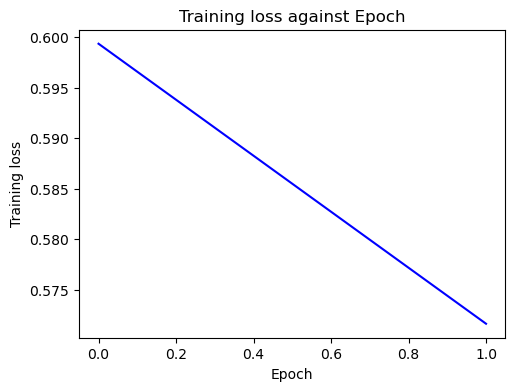

name: densenet121_model_fc10_18-09
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:12<00:00,  2.88s/it]


Train Epoch: 1/18 train loss 0.4500 Acc batch: 0.8012 learning_rate: 0.0003
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:59<00:00,  3.05s/it]


Train Epoch: 2/18 train loss 0.3603 Acc batch: 0.8509 learning_rate: 0.0003
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:24<00:00,  2.93s/it]


Train Epoch: 3/18 train loss 0.2671 Acc batch: 0.8983 learning_rate: 0.0001
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:22<00:00,  2.92s/it]


Train Epoch: 4/18 train loss 0.2041 Acc batch: 0.9184 learning_rate: 0.0001
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [13:39<00:00,  2.98s/it]


Train Epoch: 5/18 train loss 0.1106 Acc batch: 0.9681 learning_rate: 0.0000
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [16:05<00:00,  3.51s/it]


Train Epoch: 6/18 train loss 0.0545 Acc batch: 0.9850 learning_rate: 0.0000
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:10<00:00,  3.75s/it]


Train Epoch: 7/18 train loss 0.0257 Acc batch: 0.9950 learning_rate: 0.0000
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:25<00:00,  3.80s/it]


Train Epoch: 8/18 train loss 0.0261 Acc batch: 0.9950 learning_rate: 0.0000
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:23<00:00,  3.80s/it]


Train Epoch: 9/18 train loss 0.0187 Acc batch: 0.9968 learning_rate: 0.0000
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:25<00:00,  3.80s/it]


Train Epoch: 10/18 train loss 0.0324 Acc batch: 0.9941 learning_rate: 0.0000
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:18<00:00,  3.77s/it]


Train Epoch: 11/18 train loss 0.0204 Acc batch: 0.9959 learning_rate: 0.0000
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:45<00:00,  3.88s/it]


Train Epoch: 12/18 train loss 0.0144 Acc batch: 0.9977 learning_rate: 0.0000
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:54<00:00,  3.91s/it]


Train Epoch: 13/18 train loss 0.0150 Acc batch: 0.9986 learning_rate: 0.0000
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [18:09<00:00,  3.96s/it]


Train Epoch: 14/18 train loss 0.0227 Acc batch: 0.9941 learning_rate: 0.0000
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:57<00:00,  3.92s/it]


Train Epoch: 15/18 train loss 0.0267 Acc batch: 0.9941 learning_rate: 0.0000
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [18:00<00:00,  3.93s/it]


Train Epoch: 16/18 train loss 0.0318 Acc batch: 0.9932 learning_rate: 0.0000
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:37<00:00,  3.84s/it]


Train Epoch: 17/18 train loss 0.0204 Acc batch: 0.9945 learning_rate: 0.0000
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [17:38<00:00,  3.85s/it]

Train Epoch: 18/18 train loss 0.0177 Acc batch: 0.9982 learning_rate: 0.0000
Time elapsed:  17731.302421331406


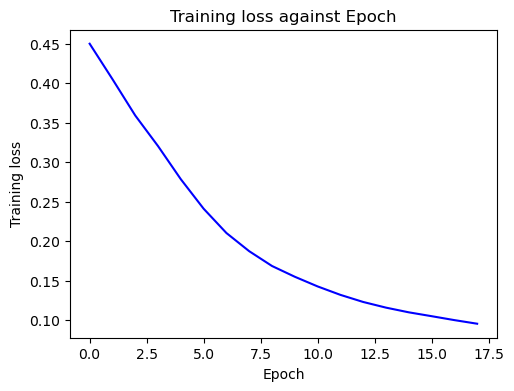

(3, 224, 224)


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:48<00:00,  5.00it/s]


              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       122
         1.0       0.84      0.89      0.86       121

    accuracy                           0.86       243
   macro avg       0.86      0.86      0.86       243
weighted avg       0.86      0.86      0.86       243



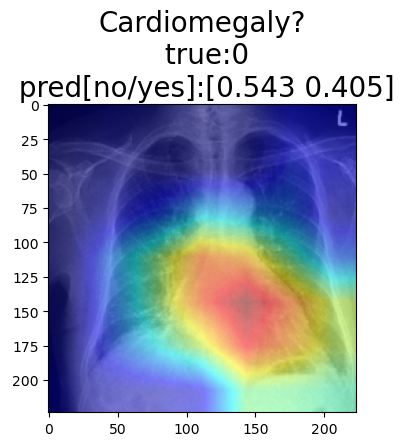

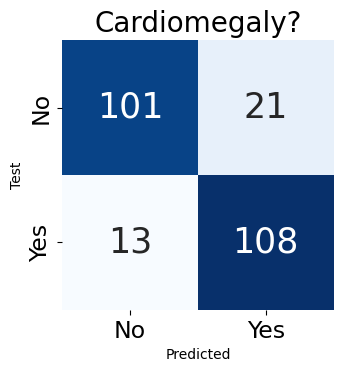

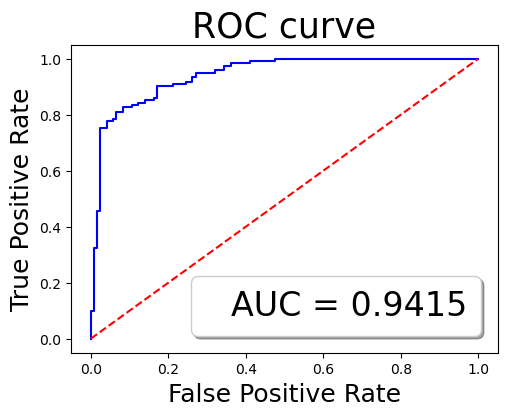

In [26]:
init_epochs = 2
train_epochs = 18

random_state = 1947
n_splits = 10
n_repeats = 1

condition = 'Cardiomegaly'
X = np.array(total_ids) 
y = np.array(total_y)
cv = KFold(n_splits=n_splits, shuffle = True, random_state = random_state)
print(cv.get_n_splits())

test_y_list_dcf10_18 = []
y_pred_prob_list_dcf10_18 = []

for fold, (train, test) in enumerate(cv.split(X, y)):

    transform_function(train, test)
    
    densenet121_model_fc10_18 = torchvision.models.densenet121(weights= 'DEFAULT')
    for param in densenet121_model_fc10_18.parameters():
        param.requires_grad = False
    densenet121_model_fc10_18.classifier = nn.Sequential(nn.Linear(densenet121_model_fc10_18.classifier.in_features, 512),
                                             torch.nn.ReLU(), nn.Linear(512, 2))
    
    densenet121_model_fc10_18 = train_func(densenet121_model_fc10_18, init_epochs, train_epochs, fold = fold)
    y_pred_prob = prob_please(densenet121_model_fc10_18, fold)
    test_y_list_dcf10_18.append(test_y_label)
    y_pred_prob_list_dcf10_18.append(y_pred_prob)
       

In [27]:
import json

In [30]:
name_model = 'densenet121_model_fc10_18'
#writing
with open(f"{result_OUT}/{name_model}_y_pred_prob_list_dcf10_18.txt", 'w') as f:
    f.write(json.dumps(y_pred_prob_list_dcf10_18))
with open(f"{result_OUT}/{name_model}_test_y_list_dcf10_18.txt", 'w') as f:
    f.write(json.dumps(test_y_list_dcf10_18))

In [31]:
#reading
with open(f"{result_OUT}/{name_model}_y_pred_prob_list_dcf10_18.txt", 'r') as f:
    y_pred_prob_list_dcf10_18 = json.loads(f.read()) 
with open(f"{result_OUT}/{name_model}_test_y_list_dcf10_18.txt", 'r') as f:
    test_y_list_dcf10_18 = json.loads(f.read()) 